In [1]:
import pybullet_envs
import gym
import pygame
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from models.ddpg import DDPG
from models.soft_actor_critic import SoftActorCritic
from rl_models.replay_buffer import ReplayBuffer
from rl_models.utils import plot_learning_curve

In [2]:
env = gym.make('Pendulum-v1')
print(env.action_space, env.observation_space.shape)
env.reset()
# env.render()

Box(-2.0, 2.0, (1,), float32) (3,)


array([ 0.9805589 , -0.19622521,  0.9919121 ], dtype=float32)

In [3]:
best_score = env.reward_range[0]
score_history = []

In [4]:
n_episodes = 250
max_size = 10_000
batch_size = 64
learning_freq = 32

In [5]:
sac = DDPG(env.observation_space.shape[0], action_dim=env.action_space.shape[0], 
           hidden_size=64, scale_action=2.0)
replay_buffer = ReplayBuffer(max_size)

In [6]:
from time import sleep

def play_and_record(env, agent, buffer):
    state = env.reset()
    done = False
    score = 0
    state = torch.tensor(state, dtype=torch.float)
    while not done:
        action = agent.choose_action(2.0 * state)
        # print(action)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        
        buffer.add(state, action, reward, next_state, done)
        # print(state, action, reward, next_state, done)
        # sleep(10)
        if len(buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            agent.learning_step(batch)
            
        state = next_state
    
    return score

iteration 240 score -843.682 avg_score -453.319


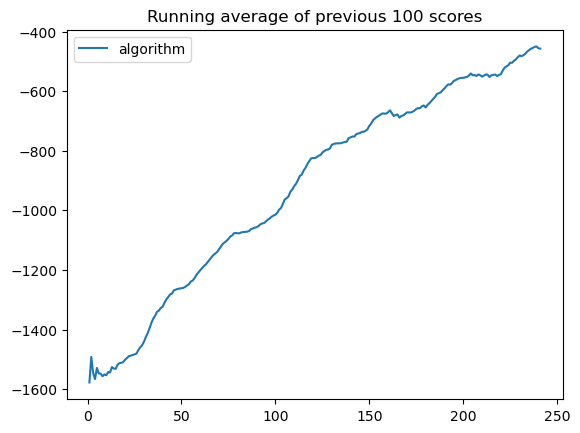

100%|██████████| 250/250 [06:23<00:00,  1.54s/it]


In [7]:
for i in tqdm(range(n_episodes)):
    score = play_and_record(env, sac, replay_buffer)
    sac.update_network_parameters()
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
    if i % 10 == 0 and i > 0:
        plot_learning_curve(len(score_history), score_history, running=True) 
        print(f"iteration {i} score {score:.3f} avg_score {avg_score:.3f}")
        plt.show()

    if avg_score > 900:
        break